In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pandas as pd
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
import PIL
from torchvision.transforms import v2

In [2]:
labels_dict = {
    'barszcz czerowny' : 1,
    'bigos' : 2,
    'kutia' : 3,
    'makowiec' : 4,
    'pierniki' : 5,
    'pierogi' : 6,
    'sernik' : 7,
    'zupa grzybowa' : 8,
}



class WigiliaDataset(Dataset):
    def __init__(self, root, csv_file, transform=None):
        self.root = root
        self.transform = transform
        self.annotations = pd.read_csv(csv_file)
        self.classes = self.annotations['label'].unique()
        self.labels_dict = {
                'barszcz czerwony' : 1,
                'bigos' : 2,
                'kutia' : 3,
                'makowiec' : 4,
                'pierniki' : 5,
                'pierogi' : 6,
                'sernik' : 7,
                'zupa grzybowa' : 8,
            }
        self.reverse_labels_dict = {v: k for k, v in self.labels_dict.items()}


    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        y_label = (self.annotations.iloc[index, 1])

        img_path = os.path.join(self.root, self.reverse_labels_dict[y_label].replace(' ','-'), self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return (image, y_label)
    
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    v2.RGB(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [3]:
dataset = WigiliaDataset(root='data', csv_file='labels.csv', transform=preprocess)

torch.Size([3, 224, 224])
1


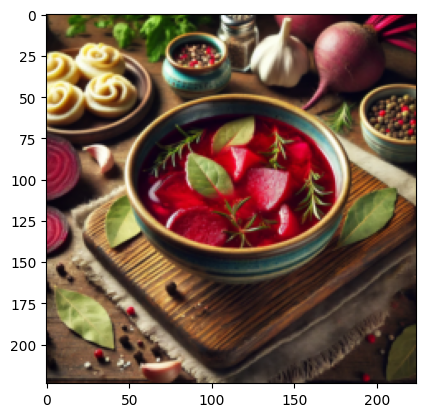

In [4]:
import matplotlib.pyplot as plt

def img_show(img):
    if isinstance(img, torch.Tensor):
        img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.show()

for img, label in dataset:
    print(img.shape)
    print(label)
    img_show(img)
    break

In [5]:
from torch.utils.data import random_split

# Define the split ratio
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
n=0
for img, label in test_loader:
    print(img.shape)
    print(label)
    n+=1
    if n==3:    
        break

torch.Size([64, 3, 224, 224])
tensor([3, 3, 5, 5, 8, 3, 2, 1, 2, 3, 7, 2, 3, 2, 7, 4, 5, 3, 8, 1, 4, 1, 2, 5,
        2, 8, 4, 5, 7, 8, 5, 3, 8, 6, 7, 1, 4, 4, 4, 3, 6, 1, 6, 7, 6, 8, 1, 4,
        7, 6, 7, 2, 6, 1, 4, 7, 8, 7, 8, 2, 4, 6, 1, 7])
torch.Size([64, 3, 224, 224])
tensor([8, 2, 3, 7, 8, 2, 5, 7, 4, 5, 7, 4, 2, 6, 2, 1, 6, 1, 7, 3, 6, 4, 5, 4,
        6, 4, 8, 6, 2, 7, 7, 2, 6, 7, 3, 3, 7, 2, 6, 3, 5, 2, 5, 5, 1, 3, 5, 4,
        6, 1, 6, 4, 6, 2, 7, 7, 2, 3, 1, 1, 2, 4, 6, 2])
torch.Size([64, 3, 224, 224])
tensor([5, 2, 8, 8, 4, 7, 8, 6, 1, 8, 3, 2, 5, 7, 7, 4, 5, 2, 3, 4, 8, 8, 2, 6,
        4, 6, 3, 4, 2, 8, 3, 1, 1, 5, 4, 8, 1, 7, 2, 7, 6, 2, 4, 2, 4, 3, 3, 6,
        6, 5, 8, 3, 4, 2, 3, 7, 5, 4, 3, 2, 5, 1, 2, 5])


In [7]:
import torchvision.models as models

class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the model with the number of classes in the dataset
num_classes = len(dataset.classes)
resnet18 = CustomResNet18(num_classes)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)



c:\Users\Dominik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dominik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import time
import torch
from tqdm.notebook import tqdm


def train_model(
    model, 
    data_loader, 
    criterion, 
    optimizer, 
    num_epochs=10, 
    device="gpu" if torch.cuda.is_available() else "cpu"
):  
    train_size = int(0.85 * len(data_loader.dataset))
    valid_size = len(data_loader.dataset) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(data_loader.dataset, [train_size, valid_size])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=data_loader.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=data_loader.batch_size, shuffle=False)

    print(f"Training on the {device.upper()}")
    model.to(device)
    
    
    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        start_time = time.time() 
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, (images, labels) in progress_bar:
            images, labels = torch.Tensor(images).to(device), torch.Tensor(labels).to(device)
            images, labels = images.to(device), labels.to(device) 
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs-1, labels-1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                progress_bar.set_postfix(current_loss=loss.item())
                running_loss = 0.0
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} completed in {epoch_time // 60:.0f} minutes and {epoch_time % 60:.0f} seconds")
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            progress_bar = tqdm(valid_loader, total=len(valid_loader), desc="Validation")
            for i, (images, labels) in enumerate(progress_bar):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs-1, labels-1)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                predicted += 1
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                if (i + 1) % 50 == 0:
                    progress_bar.set_postfix(valid_loss=valid_loss / (i + 1), accuracy=100. * correct / total)
                
        valid_loss /= len(valid_loader)
        accuracy = 100 * correct / total
        print(f"Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")
   
        
        torch.save(model.state_dict(), f"models/{type(model).__name__}_epoch_{epoch+1}.pth")


In [9]:
train_model(resnet18, train_loader, criterion, optimizer, num_epochs=10)

Training on the CPU


Epoch 1/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/10 completed in 1 minutes and 51 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.5411, Accuracy: 92.68%


Epoch 2/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/10 completed in 2 minutes and 4 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.1461, Accuracy: 97.56%


Epoch 3/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/10 completed in 1 minutes and 58 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.0641, Accuracy: 98.37%


Epoch 4/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/10 completed in 1 minutes and 59 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.0455, Accuracy: 100.00%


Epoch 5/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/10 completed in 1 minutes and 49 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.0410, Accuracy: 100.00%


Epoch 6/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/10 completed in 1 minutes and 46 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.0399, Accuracy: 100.00%


Epoch 7/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/10 completed in 2 minutes and 4 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.0364, Accuracy: 100.00%


Epoch 8/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/10 completed in 1 minutes and 51 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.0333, Accuracy: 100.00%


Epoch 9/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/10 completed in 1 minutes and 49 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.0324, Accuracy: 100.00%


Epoch 10/10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/10 completed in 2 minutes and 6 seconds


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.0298, Accuracy: 100.00%


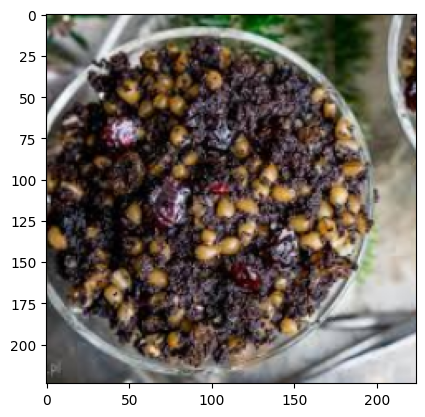

predicted:  tensor([3])
label:  tensor(3)


In [10]:
resnet18.eval()
for imgs, labels in test_loader:
    for img, label in zip(imgs, labels):
        img_show(img)
        img = img.unsqueeze(0)
        outputs = resnet18(img)
        _, predicted = torch.max(outputs.data, 1)
        predicted += 1
        print("predicted: ", predicted)
        print("label: ", label)
        break
    break

In [13]:


def evaluate_model(model, data_loader, device="gpu" if torch.cuda.is_available() else "cpu"):
    model.eval() 

    total = 0
    correct = 0

    with torch.no_grad():  # No need to compute gradients
        eval_bar = tqdm(data_loader, desc="Evaluating")
        for images, labels in eval_bar:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            predicted += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            current_acc = 100 * correct / total
            eval_bar.set_postfix(current_acc=f"{current_acc:.2f}%")

    print(f"Final Accuracy: {100 * correct / total:.2f}%")
    
    

In [14]:
evaluate_model(resnet18, test_loader)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Final Accuracy: 98.53%


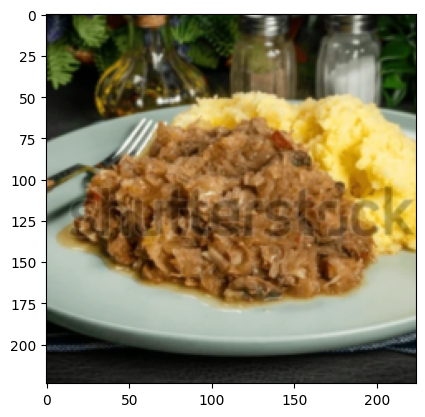

In [37]:
test_image = io.imread('test1.png')
test_image = preprocess(test_image)
img_show(test_image)

In [38]:
resnet18.eval()
test_image = test_image.unsqueeze(0)
output = resnet18(test_image)
_, predicted = torch.max(output.data, 1)
predicted += 1
print("predicted: ", predicted)
output.softmax(dim=1)


predicted:  tensor([2])


tensor([[4.7068e-04, 9.8822e-01, 1.5049e-03, 2.0335e-03, 9.8756e-04, 2.4182e-03,
         3.2145e-03, 1.1506e-03]], grad_fn=<SoftmaxBackward0>)

tensor(-0.1072, grad_fn=<SumBackward0>)